In [1]:
#important imports
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create the multi class data.
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5, # more random clusters
                           random_state= RANDOM_SEED)
#2. Turn the data into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

#3. Split into train and test
split = int(0.8 * len(X_blob))
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size= 0.2,
                                                    random_state= RANDOM_SEED)

#check that the split is correct
print(f"X_train:{len(X_train)} X_test:{len(X_test)} \ny_train:{len(y_train)} y_test:{len(y_test)}")

X_train:800 X_test:200 
y_train:800 y_test:200


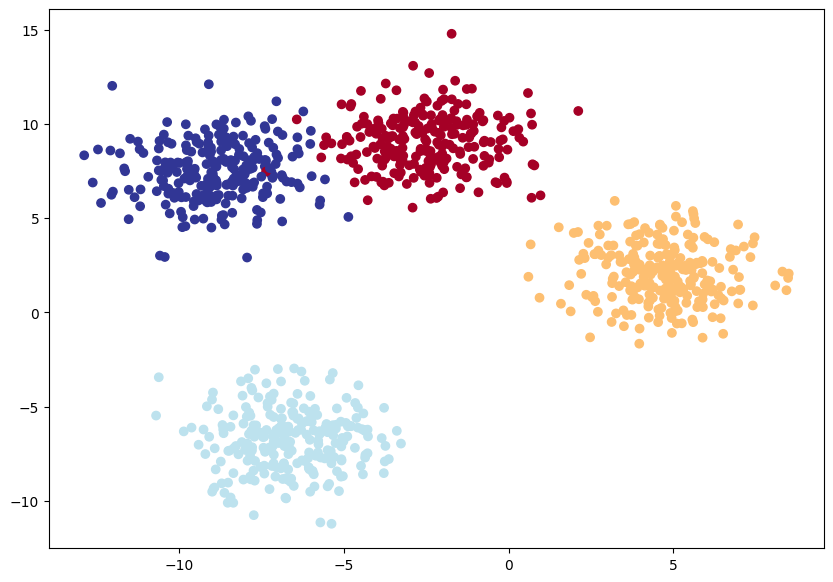

In [2]:
#4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [3]:
#create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#5. create the multiclass classification model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """Inits multiclass classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Numer of features output by the model
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:
      something

    Raises:
      nothing

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

In [5]:
def accuracy(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [6]:
#create an instance of blob model and send it to the target device
model_0 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
#create a loss fucntion and optimizer for Multi-Class Classification model
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.05)

In [8]:
#for testing set it to eval mode and try with our basic untrained model
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))

y_logits[:10]

tensor([[ 0.4396, -0.0256,  0.4840, -0.4926],
        [ 0.2146,  0.1108,  0.4245, -0.3175],
        [ 0.9396, -0.3817,  0.7294, -0.6239],
        [ 0.3779, -0.0028,  0.3857, -0.3999],
        [ 0.4818, -0.0750,  0.4568, -0.4932],
        [ 0.2838,  0.0641,  0.4396, -0.3671],
        [ 0.9070, -0.3591,  0.7022, -0.5646],
        [ 0.4466, -0.0884,  0.3720, -0.4491],
        [ 1.0474, -0.4555,  0.7968, -0.7382],
        [ 0.4570, -0.0828,  0.4002, -0.4630]], device='cuda:0')

In [9]:
# We need to convert our logits to predictions probabilities
# and then prediction labels
# Logits -> Pred Probs -> Activation Function -> Argmax
y_pred_probs = torch.softmax(y_logits,dim=1)
print(f"Raw logits data: {y_logits[:5]}")
print(f"Softmax Activation Function: {y_pred_probs[:5]}")
y_preds = torch.argmax(y_pred_probs,dim=1)
print(f" Highest Probability values: {y_preds[:5]}")


Raw logits data: tensor([[ 0.4396, -0.0256,  0.4840, -0.4926],
        [ 0.2146,  0.1108,  0.4245, -0.3175],
        [ 0.9396, -0.3817,  0.7294, -0.6239],
        [ 0.3779, -0.0028,  0.3857, -0.3999],
        [ 0.4818, -0.0750,  0.4568, -0.4932]], device='cuda:0')
Softmax Activation Function: tensor([[0.3260, 0.2048, 0.3408, 0.1284],
        [0.2686, 0.2422, 0.3314, 0.1578],
        [0.4373, 0.1167, 0.3544, 0.0916],
        [0.3174, 0.2169, 0.3199, 0.1458],
        [0.3418, 0.1959, 0.3334, 0.1289]], device='cuda:0')
 Highest Probability values: tensor([2, 2, 0, 2, 0], device='cuda:0')


In [10]:
#Create Training and Testing Loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number epochs
epochs = 100

# Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device),y_test.to(device)

#Loop through our data
for epoch in range(epochs):

  model_0.train()
  y_logits = model_0(X_train).to(device)
  #from raw data to prediction probs to the highest prob
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_train)
  acc = accuracy(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy(y_test,test_preds)


  if epoch % 10 == 0:
    print(f"Epoch: {epoch} \nTrain Loss: {loss:.4f} | Train Acc: {acc:.2f}\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epoch: 0 
Train Loss: 1.3918 | Train Acc: 24.88
Test Loss: 1.3413 | Test Acc: 49.00
Epoch: 10 
Train Loss: 1.0103 | Train Acc: 71.00
Test Loss: 1.0036 | Test Acc: 69.50
Epoch: 20 
Train Loss: 0.7248 | Train Acc: 75.25
Test Loss: 0.7174 | Test Acc: 70.50
Epoch: 30 
Train Loss: 0.3723 | Train Acc: 97.38
Test Loss: 0.3409 | Test Acc: 97.00
Epoch: 40 
Train Loss: 0.1941 | Train Acc: 99.00
Test Loss: 0.1739 | Test Acc: 98.50
Epoch: 50 
Train Loss: 0.1298 | Train Acc: 99.00
Test Loss: 0.1161 | Test Acc: 99.00
Epoch: 60 
Train Loss: 0.0986 | Train Acc: 99.00
Test Loss: 0.0877 | Test Acc: 99.00
Epoch: 70 
Train Loss: 0.0808 | Train Acc: 99.00
Test Loss: 0.0713 | Test Acc: 99.50
Epoch: 80 
Train Loss: 0.0696 | Train Acc: 99.00
Test Loss: 0.0608 | Test Acc: 99.50
Epoch: 90 
Train Loss: 0.0619 | Train Acc: 99.00
Test Loss: 0.0535 | Test Acc: 99.50


In [11]:
# make predictions and evaluate the model in a visual manner
import requests
from pathlib import Path

#download helper function if not already downloaded
if Path("helper_functions.py").is_file():
  print("file already downloaded")
else:
  r = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  print(r.status_code)
  with open("helper_functions.py","wb") as f:
    f.write(r.content)

from helper_functions import plot_predictions, plot_decision_boundary

200


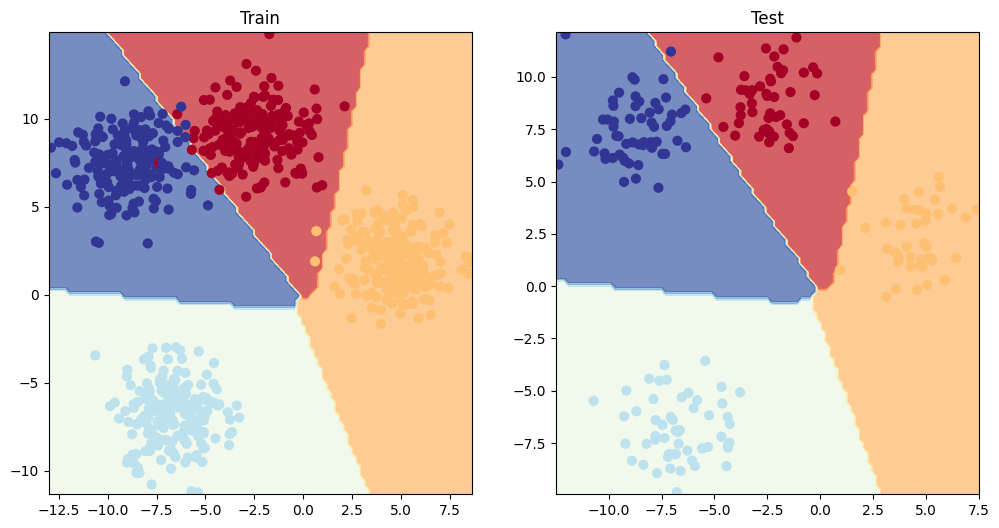

In [12]:
# Make Predictions
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)


# View the first 10 predictions
y_pred_probs = torch.softmax(y_logits,dim=1)
y_preds = y_pred_probs.argmax(dim=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)